In [47]:
import os
import math
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
% matplotlib inline  
from PIL import Image
import cv2
from scipy.stats.kde import gaussian_kde

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from tensorboardX import SummaryWriter

import logging
import imp
imp.reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')

In [64]:
class MLTData():
    def __init__(self, batch_size=32, image_size=128, orig_image_size=[480, 640], train_proportion=1):
        self.name = 'mlt'
        self.img_dir = '/media/yi/DATA/data-orig/MLT/image'
        self.box_dir = '/home/yi/code/few_shot/mlt/box'
        self.meta = self.get_meta(self.img_dir, self.box_dir)
 
        self.train_meta = self.assign_meta('train')
        self.test_meta = self.assign_meta('test')
        
        self.batch_size = batch_size
        self.im_size = image_size
        self.orig_im_size = orig_image_size
        self.train_proportion = train_proportion
        num_image = len(self.train_meta['img'])
        self.train_meta['img'] = self.train_meta['img'][0:int(num_image * train_proportion)]
        self.train_meta['box'] = self.train_meta['box'][0:int(num_image * train_proportion)]
        self.train_idx = np.random.permutation(len(self.train_meta['img']))
        self.train_cnt = 0
        self.test_idx = np.random.permutation(len(self.test_meta['img']))
        self.test_cnt = 0
        
        print('number of training image: %d, number of testing image: %d' % 
              (len(self.train_meta['img']), len(self.test_meta['img'])))
        self.compute_statistics('train')
        self.compute_statistics('test')
        
        self.class_map = {3:0, 4:1, 5:2, 6:3, 13:4, 24:5}
        
    def get_meta(self, img_dir, box_dir):
        meta = {}
        meta['img'], meta['box'] = [], []
        for sub_dir in os.listdir(box_dir):
            box_files = os.listdir(os.path.join(box_dir, sub_dir))
            box_files.sort(key=lambda f: int(filter(str.isdigit, f)))
            box_file_names = [os.path.join(box_dir, sub_dir, f) for f in box_files]
            img_files = []
            for f in box_files:
                file_name, file_ext = os.path.splitext(f)
                img_files.append(file_name + '_color.jpg')
            img_file_names = [os.path.join(img_dir, sub_dir, f) for f in img_files]
            meta['img'].extend(img_file_names)
            meta['box'].extend(box_file_names)
        return meta
    
    def assign_meta(self, status='train'):
        num_image = len(self.meta['img'])
        if status == 'train':
            meta = {}
            meta['img'] = self.meta['img'][0:int(num_image * 0.7)]
            meta['box'] = self.meta['box'][0:int(num_image * 0.7)]
        else:
            meta = {}
            meta['img'] = self.meta['img'][int(num_image * 0.7):]
            meta['box'] = self.meta['box'][int(num_image * 0.7):]
        return meta
    
    def compute_statistics(self, status='train'):
        if status == 'train':
            box_meta = self.train_meta['box']
        else:
            box_meta = self.test_meta['box']
        box = []
        for box_file_name in box_meta:
            with open(box_file_name) as txt_file:
                box_info = txt_file.readlines()
            for row in box_info:
                row = row.strip().split(' ')
                box.append(row)
        box = np.array(box).astype(np.int)

        cls = box[:, 4]
        box = box[:, 0:4]
        cls_labels = set(list(cls))
        count = dict()
        max_count = 0
        total_count = 0
        for cls_label in cls_labels:
            count[cls_label] = (cls == cls_label).sum()
            if count[cls_label] > max_count:
                max_count = count[cls_label]
            total_count = total_count + count[cls_label]
        print(status)
        print(count)
        print(max_count * 1.0 / total_count)
        
        x = (box[:, 0] + box[:, 2]) / 2.0 / 640
        y = (box[:, 1] + box[:, 3]) / 2.0 / 480
        w = (box[:, 2] - box[:, 0]) * 1.0 / 640
        h = (box[:, 3] - box[:, 1]) * 1.0 / 480
        print(np.min(x), np.max(x), np.mean(x), np.median(x))
        print(np.min(y), np.max(y), np.mean(y), np.median(y))
        print(np.min(w), np.max(w), np.mean(w), np.median(w))
        print(np.min(h), np.max(h), np.mean(h), np.median(h))
        plt.subplots(1)
        plt.scatter(x, y)
        plt.subplots(1)
        plt.scatter(w, h)
        
        num_bins = 100
        counts, bin_edges = np.histogram(x, bins=num_bins, range=[0, 1], normed=True)
        cdf = np.cumsum(counts)
        plt.subplots(1)
        plt.plot(bin_edges[1:], cdf)
        plt.show()
        counts, bin_edges = np.histogram(y, bins=num_bins, range=[0, 1], normed=True)
        cdf = np.cumsum(counts)
        plt.subplots(1)
        plt.plot(bin_edges[1:], cdf)
        plt.show()
        counts, bin_edges = np.histogram(w, bins=num_bins, range=[0, 1], normed=True)
        cdf = np.cumsum(counts)
        plt.subplots(1)
        plt.plot(bin_edges[1:], cdf)
        plt.show()
        counts, bin_edges = np.histogram(h, bins=num_bins, range=[0, 1], normed=True)
        cdf = np.cumsum(counts)
        plt.subplots(1)
        plt.plot(bin_edges[1:], cdf)
        plt.show()
        
        # x, y, w, h = np.log(x), np.log(y), np.log(w), np.log(h)
        w, h = np.log(w), np.log(h)
        fig, ax = plt.subplots(1)
        k = gaussian_kde(np.vstack([x, y]))
        xi, yi = np.mgrid[0:1:0.01, 0:1:0.01]
        # xi, yi = np.mgrid[np.log(0.1):0:0.1, np.log(0.1):0:0.1]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))
        # ax.pcolormesh(xi, yi, zi.reshape(xi.shape))
        ax.contourf(xi, yi, zi.reshape(xi.shape))
        fig, ax = plt.subplots(1)
        k = gaussian_kde(np.vstack([w, h]))
        # xi, yi = np.mgrid[0:1:0.01, 0:1:0.01]
        xi, yi = np.mgrid[np.log(0.1):0:0.1, np.log(0.1):0:0.1]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))
        # ax.pcolormesh(xi, yi, zi.reshape(xi.shape))
        ax.contourf(xi, yi, zi.reshape(xi.shape))
        plt.show()

    def get_next_batch(self, status='train'):
        batch_size, im_size, orig_im_size = self.batch_size, self.im_size, self.orig_im_size
        im = np.zeros((batch_size, im_size, im_size, 3))
        orig_im = np.zeros((batch_size, orig_im_size[0], orig_im_size[1], 3))
        direction = np.zeros((batch_size, 4))
        boxes = np.zeros((batch_size, 4))
        label = np.zeros(batch_size)
        i = 0
        restart = False
        while i < batch_size:
            if status == 'train':
                image_name = self.train_meta['img'][self.train_idx[self.train_cnt]]
                box_name = self.train_meta['box'][self.train_idx[self.train_cnt]]
            else:
                image_name = self.test_meta['img'][self.test_idx[self.test_cnt]]
                box_name = self.test_meta['box'][self.test_idx[self.test_cnt]]
            image = np.array(Image.open(image_name))
            im_height, im_width = image.shape[0], image.shape[1]
            image = image / 255.0
            
            box = []
            with open(box_name) as txt_file:
                box_info = txt_file.readlines()
            for row in box_info:
                row = row.strip().split(' ')
                box.append(row)
            box = np.array(box).astype(np.int)
            
            if status == 'train':
                self.train_cnt = self.train_cnt + 1
                if self.train_cnt >= len(self.train_meta['img']):
                    self.train_idx = np.random.permutation(len(self.train_meta['img']))
                    self.train_cnt = 0
                    restart = True
            else:
                self.test_cnt = self.test_cnt + 1
                if self.test_cnt >= len(self.test_meta['img']):
                    self.test_idx = np.random.permutation(len(self.test_meta['img']))
                    self.test_cnt = 0
                    restart = True
            
            for n in range(box.shape[0]):
                cls = box[n, 4]
                bb = box[n, 0:4]
                im[i, :, :, :] = cv2.resize(image, (im_size, im_size), interpolation=cv2.INTER_AREA)
                orig_im[i, :, :, :] = cv2.resize(image, (orig_im_size[1], orig_im_size[0]), interpolation=cv2.INTER_AREA)
                boxes[i, 0] = bb[0] * 1.0 / im_width
                boxes[i, 1] = bb[1] * 1.0 / im_height
                boxes[i, 2] = bb[2] * 1.0 / im_width
                boxes[i, 3] = bb[3] * 1.0 / im_height
                x_c = (bb[0] + bb[2]) * 1.0 / 2 / im_width
                y_c = (bb[1] + bb[3]) * 1.0 / 2 / im_height
                width = (bb[2] - bb[0]) * 1.0 / im_width
                height = (bb[3] - bb[1]) * 1.0 / im_height
                if x_c < 0.3:
                    direction[i, 0] = 1
                elif x_c < 0.5:
                    direction[i, 0] = 2
                elif x_c < 0.7:
                    direction[i, 0] = 3
                else:
                    direction[i, 0] = 4
                if y_c < 0.6:
                    direction[i, 1] = 1
                elif y_c < 0.8:
                    direction[i, 1] = 2
                else:
                    direction[i, 1] = 3
                if width < 0.3:
                    direction[i, 2] = 1
                elif width < 0.5:
                    direction[i, 2] = 2
                else:
                    direction[i, 2] = 3
                if height < 0.375:
                    direction[i, 3] = 1
                elif height < 0.5:
                    direction[i, 3] = 2
                else:
                    direction[i, 3] = 3
                label[i] = self.class_map[cls]
                i = i + 1
                if i >= batch_size:
                    break
        im = im.transpose((0, 3, 1, 2))
        orig_im = orig_im.transpose((0, 3, 1, 2))
        return im, orig_im, boxes, direction, label, restart
    
    def display(self, im, orig_im, box, direction, label):
        # Plot original large image with bounding box
        orig_im = orig_im[0, :, :, :].transpose(1, 2, 0)
        fig, ax = plt.subplots(1)
        ax.imshow(orig_im)
        
        b = box[0, 0:4].copy()
        im_height, im_width = orig_im.shape[0], orig_im.shape[1]
        b[0], b[1], b[2], b[3] = b[0] * im_width, b[1] * im_height, b[2] * im_width, b[3] * im_height
        rect = patches.Rectangle((b[0], b[1]), b[2] - b[0], b[3] - b[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        
        # Plot resized image with bounding box
        im = im[0, :, :, :].transpose(1, 2, 0)
        fig, ax = plt.subplots(1)
        ax.imshow(im)
        
        b = box[0, 0:4].copy()
        im_height, im_width = im.shape[0], im.shape[1]
        b[0], b[1], b[2], b[3] = b[0] * im_width, b[1] * im_height, b[2] * im_width, b[3] * im_height
        rect = patches.Rectangle((b[0], b[1]), b[2] - b[0], b[3] - b[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        
        plt.show()
        print(direction[0, :], label[0])

number of training image: 10742, number of testing image: 4605
train
{3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}
0.25939754780765933
(0.1, 0.9, 0.4997509097961552, 0.5)
(0.13333333333333333, 0.8666666666666667, 0.7326732975091242, 0.7645833333333333)
(0.2, 1.0, 0.4115078176245017, 0.35625)
(0.26666666666666666, 1.0, 0.41066022503658106, 0.39166666666666666)


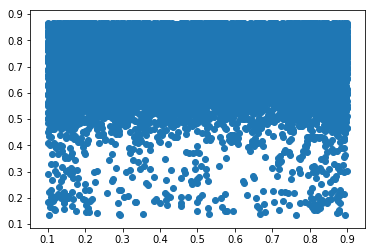

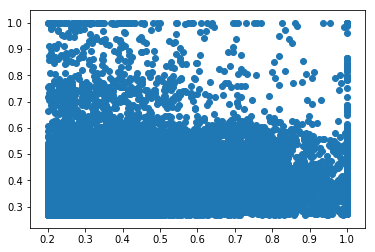

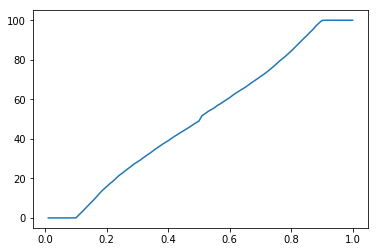

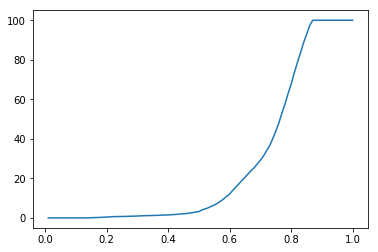

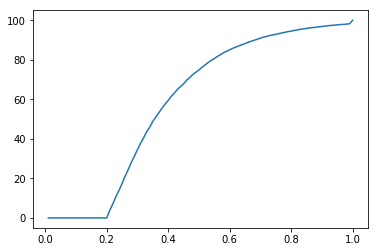

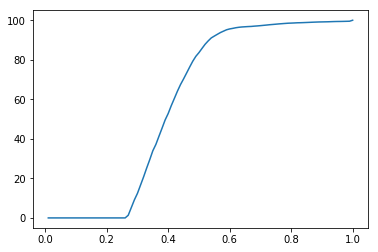

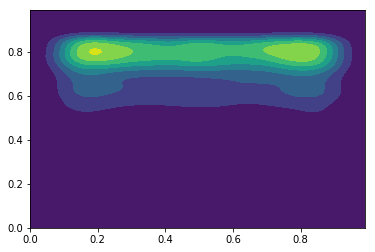

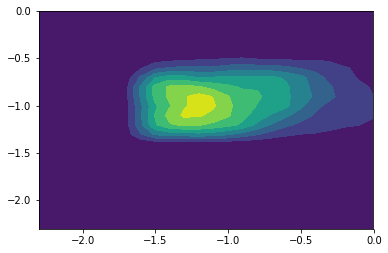

test
{3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}
0.25585542741647843
(0.1, 0.9, 0.49978190762097247, 0.5)
(0.13333333333333333, 0.8666666666666667, 0.7308772242698055, 0.7614583333333333)
(0.2, 1.0, 0.41143331649031034, 0.35625)
(0.26666666666666666, 1.0, 0.41191297110926167, 0.39375)


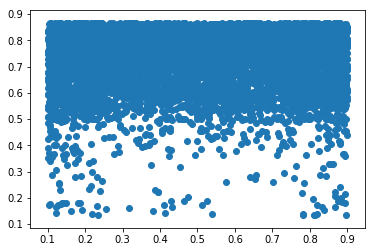

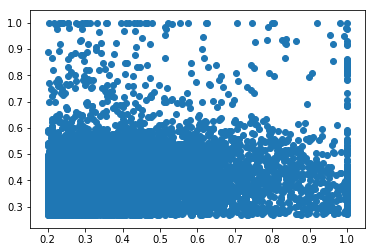

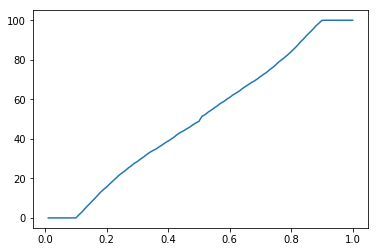

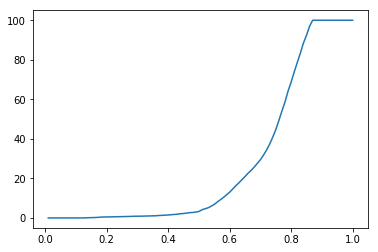

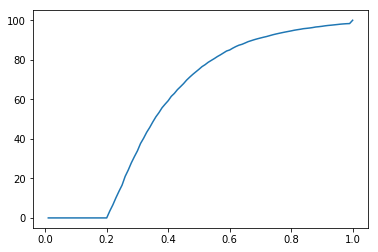

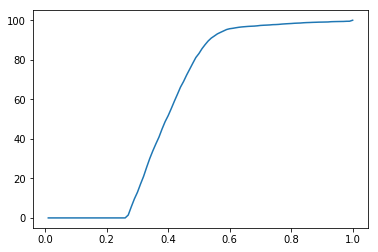

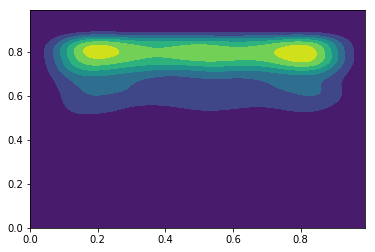

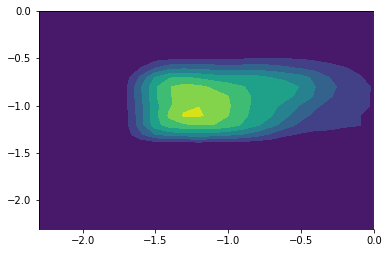

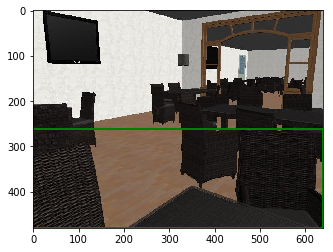

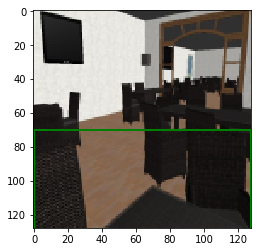

(array([2., 3., 3., 2.]), 3.0)


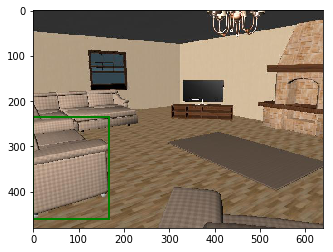

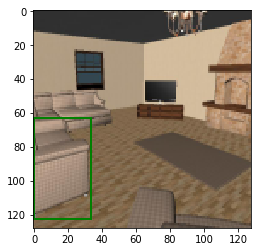

(array([1., 3., 1., 2.]), 2.0)


In [63]:
batch_size = 32
image_size = 128
orig_image_size = [480, 640]
train_proportion = 1
data = MLTData(batch_size, image_size, orig_image_size, train_proportion)
im, orig_im, box, direction, label, _ = data.get_next_batch('train')
data.display(im, orig_im, box, direction, label)
im, orig_im, box, direction, label, _ = data.get_next_batch('test')
data.display(im, orig_im, box, direction, label)

number of training image: 10742, number of testing image: 4605
train
{3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}
0.25939754780765933
test
{3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}
0.25585542741647843


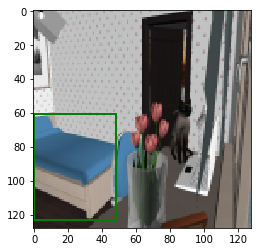

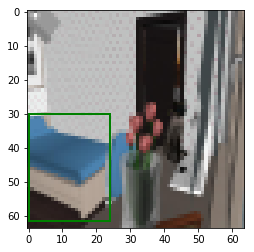

(array([1., 3., 2., 2.]), 0.0)


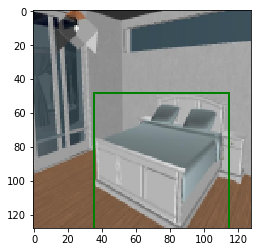

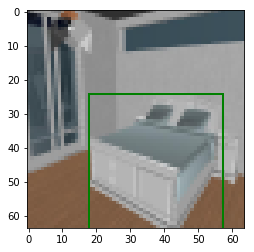

(array([2., 3., 2., 2.]), 0.0)


In [4]:
batch_size = 32
image_size = 64
orig_image_size = [128, 128]
train_proportion = 1
data = MLTData(batch_size, image_size, orig_image_size, train_proportion)
im, orig_im, box, direction, label, _ = data.get_next_batch('train')
data.display(im, orig_im, box, direction, label)
im, orig_im, box, direction, label, _ = data.get_next_batch('test')
data.display(im, orig_im, box, direction, label)

In [6]:
class BaseDirectionAttnDemo(object):
    def __init__(self, learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, 
                 image_size, orig_image_size, image_channel, direction_dim, num_class, tensorboard_path, init_model_path, 
                 train_proportion=1):
        logging.info('Baseline with bounding box crop estimated by direction only demo')
        self.learning_rate = learning_rate
        self.train_epoch = train_epoch
        self.test_epoch = test_epoch
        self.test_interval = test_interval
        self.save_interval = save_interval
        self.save_dir = save_dir
        self.best_test_acc = -1e10
        self.batch_size = batch_size
        self.im_size = image_size
        self.orig_im_size = orig_image_size
        self.im_channel = image_channel
        self.direction_dim = direction_dim
        self.n_class = num_class
        self.tensorboard_path = tensorboard_path
        self.init_model_path = init_model_path
        self.data = MLTData(batch_size, image_size, orig_image_size, train_proportion)
        self.model = self.init_model()

    def init_model(self):
        self.model = BaseDirectionAttnNet(self.batch_size, self.im_size, self.im_channel, self.direction_dim, self.n_class)
        if torch.cuda.is_available():
            # model = torch.nn.DataParallel(model).cuda()
            self.model = self.model.cuda()
        if self.init_model_path is not '':
            self.model.load_state_dict(torch.load(self.init_model_path))
        return self.model

    def train(self):
        writer = SummaryWriter(self.tensorboard_path)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_loss_all, train_acc_all = [], []
        for epoch in range(self.train_epoch):
            optimizer.zero_grad()
            im, orig_im, box, direction, label, _ = self.data.get_next_batch('train')
            orig_im = Variable(torch.from_numpy(orig_im).float())
            direction = Variable(torch.from_numpy(direction).float())
            label = Variable(torch.from_numpy(label).long())
            if torch.cuda.is_available():
                orig_im, direction, label = orig_im.cuda(), direction.cuda(), label.cuda()
            pred = self.model(orig_im, direction)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()

            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            
            writer.add_scalar('train_loss', loss.data[0], epoch)
            train_loss_all.append(loss.data[0])
            if len(train_loss_all) > 100:
                train_loss_all.pop(0)
            ave_train_loss = sum(train_loss_all) / float(len(train_loss_all))
            logging.info('epoch %d, train loss: %.2f, average train loss: %.2f', epoch, loss.data[0], ave_train_loss)
            writer.add_scalar('train_acc', acc, epoch)
            train_acc_all.append(acc)
            if len(train_acc_all) > 100:
                train_acc_all.pop(0)
            ave_train_acc = sum(train_acc_all) / float(len(train_acc_all))
            logging.info('epoch %d, train accuracy: %.2f, average train accuracy: %.2f', epoch, acc, ave_train_acc)
            if (epoch+1) % self.save_interval == 0:
                logging.info('epoch %d, saving model', epoch)
                with open(os.path.join(self.save_dir, '%d.pth' % epoch), 'w') as handle:
                    torch.save(self.model.state_dict(), handle)
            if (epoch+1) % self.test_interval == 0:
                logging.info('epoch %d, testing', epoch)
                test_loss, test_acc = self.validate()
                writer.add_scalar('test_loss', test_loss, epoch)
                writer.add_scalar('test_acc', test_acc, epoch)
        writer.close()

    def validate(self):
        test_loss, test_acc = self.test()
        if test_acc >= self.best_test_acc:
            logging.info('model save to %s', os.path.join(self.save_dir, 'model.pth'))
            with open(os.path.join(self.save_dir, 'model.pth'), 'w') as handle:
                torch.save(self.model.state_dict(), handle)
            self.best_test_acc = test_acc
        logging.info('current best test accuracy: %.2f', self.best_test_acc)
        return test_loss, test_acc

    def test(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        for epoch in range(self.test_epoch):
            im, orig_im, box, direction, label, _ = self.data.get_next_batch('test')
            orig_im = Variable(torch.from_numpy(orig_im).float(), volatile=True)
            direction = Variable(torch.from_numpy(direction).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                orig_im, direction, label = orig_im.cuda(), direction.cuda(), label.cuda()
            pred = self.model(orig_im, direction)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)

            test_loss_all.append(loss.data[0])
            if len(test_loss_all) > 100:
                test_loss_all.pop(0)
            test_acc_all.append(acc)
            if len(test_acc_all) > 100:
                test_acc_all.pop(0)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('average test loss: %.2f', test_loss)
        logging.info('average test accuracy: %.2f', test_acc)
        return test_loss, test_acc
    
    def test_all(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        self.data.test_cnt = 0 # Restart from the first testing batch, note that this is important if you test() before.
        while True:
            im, orig_im, box, direction, label, restart = self.data.get_next_batch('test')
            if restart:
                break
            orig_im = Variable(torch.from_numpy(orig_im).float(), volatile=True)
            direction = Variable(torch.from_numpy(direction).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                orig_im, direction, label = orig_im.cuda(), direction.cuda(), label.cuda()
            pred = self.model(orig_im, direction)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            test_loss_all.append(loss.data[0])
            test_acc_all.append(acc)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('overall average test loss: %.2f', test_loss)
        logging.info('overall average test accuracy: %.2f', test_acc)
        
    def visualize(self, display=True):
        im, orig_im, box, direction, label, _ = self.data.get_next_batch('test')
        orig_im = Variable(torch.from_numpy(orig_im).float(), volatile=True)
        direction = Variable(torch.from_numpy(direction).float(), volatile=True)
        label = Variable(torch.from_numpy(label).long(), volatile=True)
        if torch.cuda.is_available():
            orig_im, direction, label = orig_im.cuda(), direction.cuda(), label.cuda()
        pred = self.model(orig_im, direction, display)

In [67]:
class BaseDirectionAttnNet(nn.Module):
    def __init__(self, batch_size, im_size, im_channel, direction_dim, n_class):
        super(BaseDirectionAttnNet, self).__init__()
        num_hidden = 32
        self.bn0 = nn.BatchNorm2d(im_channel)
        self.conv1 = nn.Conv2d(im_channel, num_hidden, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden*2, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(num_hidden*2)
        self.conv3 = nn.Conv2d(num_hidden*2, num_hidden*4, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(num_hidden*4)
        self.conv4 = nn.Conv2d(num_hidden*4, num_hidden*8, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(num_hidden*8)
        self.conv5 = nn.Conv2d(num_hidden*8, num_hidden*16, 3, 1, 1)
        self.bn5 = nn.BatchNorm2d(num_hidden*16)
        self.conv6 = nn.Conv2d(num_hidden*16, num_hidden*32, 3, 1, 1)
        self.bn6 = nn.BatchNorm2d(num_hidden*32)
        if im_size >= 32:
            self.avgpool = nn.AvgPool2d(im_size / 32, stride=1)
            self.fc = nn.Linear(num_hidden*32, n_class)
        elif im_size >= 16:
            self.avgpool = nn.AvgPool2d(im_size / 16, stride=1)
            self.fc = nn.Linear(num_hidden*16, n_class)
        elif im_size >= 8:
            self.avgpool = nn.AvgPool2d(im_size / 8, stride=1)
            self.fc = nn.Linear(num_hidden*8, n_class)

        self.maxpool = nn.MaxPool2d(2, stride=2, return_indices=False, ceil_mode=False)

        self.bn_d0 = nn.BatchNorm1d(direction_dim)
        # self.fc_d1 = nn.Linear(direction_dim, num_hidden)
        # self.bn_d1 = nn.BatchNorm1d(num_hidden)
        # self.fc_box = nn.Linear(num_hidden, 4)
        self.fc_box = nn.Linear(direction_dim, 4)
        # self.fc_box.weight.data.zero_()
        # self.fc_box.bias.data.zero_()
        # self.fc_box.bias.data.copy_(torch.FloatTensor([1, 0, 0]))
        
        grid = np.mgrid[0:im_size, 0:im_size]
        grid = np.tile(grid, [batch_size, 1, 1, 1])
        self.grid = Variable(torch.from_numpy(grid).float(), requires_grad=False)
        if torch.cuda.is_available():
            self.grid = self.grid.cuda()
        
        self.batch_size = batch_size
        self.im_size = im_size

    def stn(self, direction):
        d0 = self.bn_d0(direction)
        # d1 = F.relu(self.bn_d1(self.fc_d1(d0)))
        # box = self.fc_box(d1)
        box = self.fc_box(d0)
        return box
        
    def crop_image(self, im, box):
        # Adjust box scale w.r.t. an image in the coordinate system [-1, 1] for spatial transformer usage
        # The minimum bounding box will be 0.2 * [480, 640] = [96, 128], the maximum will be [384, 512]
        # The minimum center of box will be 0.1 * [480, 640] = [48, 64], the maximum will be [432, 576]
        box = F.sigmoid(box)
        # bbox = torch.zeros_like(box)
        # bbox[:, 0] = box[:, 0] * (0.9 - 0.1) + 0.1
        # bbox[:, 1] = box[:, 1] * (0.9 - 0.1) + 0.1
        # bbox[:, 2] = box[:, 2] * (0.8 - 0.2) + 0.2
        # bbox[:, 3] = box[:, 3] * (0.8 - 0.2) + 0.2
        boxes = torch.zeros_like(box)
        # boxes[:, 0] = bbox[:, 0] - bbox[:, 2] / 2.0
        # boxes[:, 1] = bbox[:, 1] - bbox[:, 3] / 2.0
        # boxes[:, 2] = bbox[:, 0] + bbox[:, 2] / 2.0
        # boxes[:, 3] = bbox[:, 1] + bbox[:, 3] / 2.0
        boxes[:, 0] = box[:, 0] - box[:, 2]
        boxes[:, 1] = box[:, 1] - box[:, 3]
        boxes[:, 2] = box[:, 0] + box[:, 2]
        boxes[:, 3] = box[:, 1] + box[:, 3]
        boxes = F.relu(boxes)
        boxes = 1 - F.relu(1 - boxes)
        bb = boxes * 2 - 1
        # Compute the sampling distance for every pixel in the box
        sample_dist_x = (bb[:, 2] - bb[:, 0]) / self.im_size
        sample_dist_y = (bb[:, 3] - bb[:, 1]) / self.im_size
        start_x = bb[:, 0]
        start_y = bb[:, 1]
        
        grid_x = self.grid[:, 1, :, :] * sample_dist_x[:, None, None] + start_x[:, None, None]
        grid_y = self.grid[:, 0, :, :] * sample_dist_y[:, None, None] + start_y[:, None, None]
        grid = torch.stack((grid_x, grid_y), 3)       
        
        crop_im = F.grid_sample(im, grid)
        return crop_im, boxes
        
    def forward(self, orig_im, direction, display=False):
        box = self.stn(direction)
        # predict using attention area from spatial transformer network on high resolution image second
        crop_im, boxes = self.crop_image(orig_im, box)
        if display:
            self.show_box(orig_im, boxes, direction, crop_im)    
        x = self.bn0(crop_im)
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = self.maxpool(x1)
        x2 = F.relu(self.bn2(self.conv2(x2)))
        x3 = self.maxpool(x2)
        x3 = F.relu(self.bn3(self.conv3(x3)))
        x4 = self.maxpool(x3)
        x4 = F.relu(self.bn4(self.conv4(x4)))
        if self.im_size < 16:
            x = self.avgpool(x4)
        elif self.im_size < 32:
            x5 = self.maxpool(x4)
            x5 = F.relu(self.bn5(self.conv5(x5)))
            x = self.avgpool(x5)
        else:
            x5 = self.maxpool(x4)
            x5 = F.relu(self.bn5(self.conv5(x5)))
            x6 = self.maxpool(x5)
            x6 = F.relu(self.bn6(self.conv6(x6)))
            x = self.avgpool(x6)
        x = x.view(x.size(0), -1)
        pred = self.fc(x)
        return pred
    
    def show_box(self, im, box, direction, crop_im):
        im = im.cpu().data.numpy()
        im = im[0, :, :, :].transpose(1, 2, 0)
        
        fig, ax = plt.subplots(1)
        ax.imshow(im)

        box = box.cpu().data.numpy()
        b = box[0, 0:4].copy()
        im_height, im_width = im.shape[0], im.shape[1]
        b[0], b[1], b[2], b[3] = b[0] * im_width, b[1] * im_height, b[2] * im_width, b[3] * im_height
        rect = patches.Rectangle((b[0], b[1]), b[2] - b[0], b[3] - b[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        
        crop_im = crop_im.cpu().data.numpy()
        crop_im = crop_im[0, :, :, :].transpose(1, 2, 0)
        fig, ax = plt.subplots(1)
        ax.imshow(crop_im)
        plt.show()
        
        direction = direction.cpu().data.numpy()
        direction = direction[0, :]
        print(direction, box)

04:08:17 INFO:Baseline with bounding box crop estimated by direction only demo


number of training image: 10742, number of testing image: 4605
train
{3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}
0.25939754780765933
test
{3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}
0.25585542741647843


04:08:18 INFO:epoch 0, train loss: 1.77, average train loss: 1.77
04:08:18 INFO:epoch 0, train accuracy: 0.22, average train accuracy: 0.22
04:08:19 INFO:epoch 1, train loss: 2.16, average train loss: 1.96
04:08:19 INFO:epoch 1, train accuracy: 0.12, average train accuracy: 0.17
04:08:20 INFO:epoch 2, train loss: 1.95, average train loss: 1.96
04:08:20 INFO:epoch 2, train accuracy: 0.20, average train accuracy: 0.18
04:08:21 INFO:epoch 3, train loss: 1.80, average train loss: 1.92
04:08:21 INFO:epoch 3, train accuracy: 0.34, average train accuracy: 0.22
04:08:22 INFO:epoch 4, train loss: 1.92, average train loss: 1.92
04:08:22 INFO:epoch 4, train accuracy: 0.16, average train accuracy: 0.21
04:08:23 INFO:epoch 5, train loss: 1.82, average train loss: 1.90
04:08:23 INFO:epoch 5, train accuracy: 0.22, average train accuracy: 0.21
04:08:24 INFO:epoch 6, train loss: 1.71, average train loss: 1.88
04:08:24 INFO:epoch 6, train accuracy: 0.28, average train accuracy: 0.22
04:08:25 INFO:epoch 

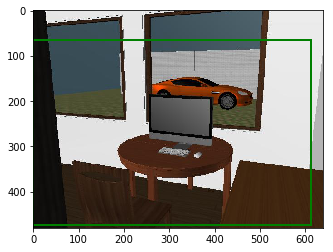

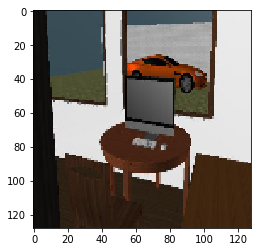

(array([3., 3., 2., 1.], dtype=float32), array([[0.        , 0.13422441, 0.9571036 , 0.98509455],
       [0.        , 0.04429197, 0.9019789 , 1.        ],
       [0.        , 0.13453269, 0.9559222 , 0.98282623],
       [0.2448541 , 0.        , 1.        , 0.6130372 ],
       [0.        , 0.17098731, 1.        , 1.        ],
       [0.        , 0.04445601, 0.90136504, 1.        ],
       [0.        , 0.        , 0.8390688 , 0.75424874],
       [0.        , 0.08536541, 0.96457094, 1.        ],
       [0.        , 0.        , 0.8390688 , 0.75424874],
       [0.        , 0.13453269, 0.9559222 , 0.98282623],
       [0.        , 0.07927138, 0.8908964 , 0.7201782 ],
       [0.        , 0.07917404, 0.8914869 , 0.7212297 ],
       [0.        , 0.        , 0.8390688 , 0.75424874],
       [0.        , 0.04429197, 0.9019789 , 1.        ],
       [0.        , 0.        , 0.8403498 , 0.756423  ],
       [0.        , 0.        , 0.8397092 , 0.75533557],
       [0.        , 0.        , 0.8390688 , 0.7

In [61]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = 128
orig_im_size = [480, 640]
im_channel = 3
direction_dim = 4
n_class = 6
tensorboard_path = './tensorboard/2d_base_direction_attn_100_1'
init_model_path = ''
train_proportion = 1
demo = BaseDirectionAttnDemo(learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, im_size, 
                    orig_im_size, im_channel, direction_dim, n_class, tensorboard_path, init_model_path, train_proportion)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()
    
demo.test_all()
demo.visualize()

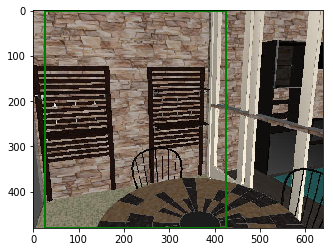

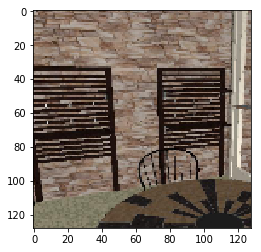

(array([2., 3., 3., 2.], dtype=float32), array([[0.04065937, 0.        , 0.6663451 , 1.        ],
       [0.        , 0.26014137, 1.        , 0.9257773 ],
       [0.        , 0.25242662, 1.        , 0.92988193],
       [0.04065937, 0.        , 0.6663451 , 1.        ],
       [0.03512734, 0.        , 0.9813892 , 0.94414425],
       [0.        , 0.        , 0.733793  , 1.        ],
       [0.        , 0.26644802, 0.9120984 , 1.        ],
       [0.        , 0.23344004, 1.        , 1.        ],
       [0.        , 0.26014137, 1.        , 0.9257773 ],
       [0.04065937, 0.        , 0.6663451 , 1.        ],
       [0.        , 0.2865851 , 1.        , 1.        ],
       [0.        , 0.2550944 , 1.        , 1.        ],
       [0.        , 0.22385716, 0.88584083, 1.        ],
       [0.04065937, 0.        , 0.6663451 , 1.        ],
       [0.06024909, 0.        , 0.98879635, 0.9956962 ],
       [0.        , 0.        , 0.8798716 , 0.9511979 ],
       [0.        , 0.22385716, 0.88584083, 1. 

In [57]:
demo.visualize()

10:50:56 INFO:Baseline with bounding box crop estimated by direction only demo


number of training image: 10742, number of testing image: 4605
train
{3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}
0.25939754780765933
(0.1, 0.9, 0.4997509097961552, 0.5)
(0.13333333333333333, 0.8666666666666667, 0.7326732975091242, 0.7645833333333333)
(0.2, 1.0, 0.4115078176245017, 0.35625)
(0.26666666666666666, 1.0, 0.41066022503658106, 0.39166666666666666)


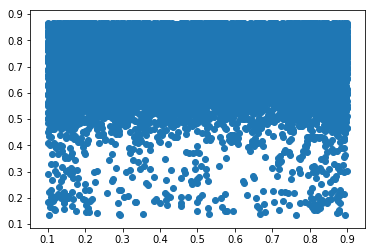

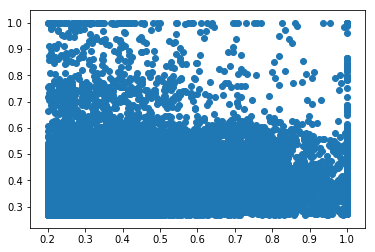

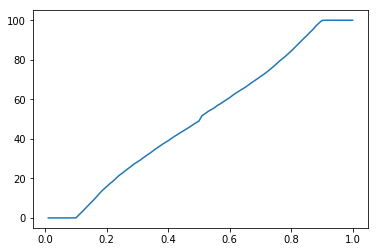

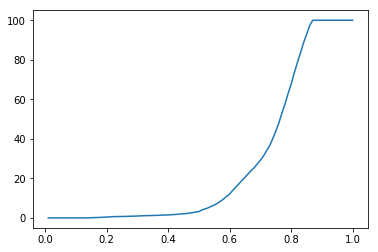

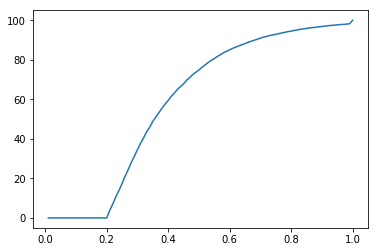

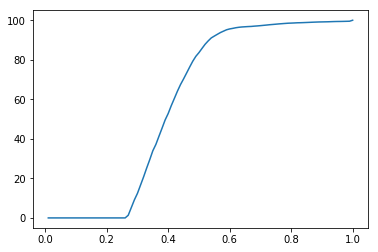

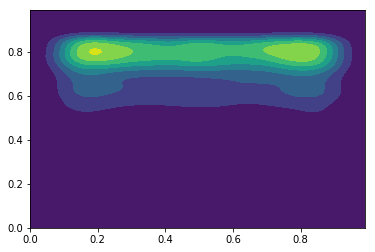

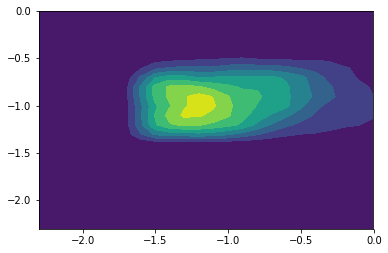

test
{3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}
0.25585542741647843
(0.1, 0.9, 0.49978190762097247, 0.5)
(0.13333333333333333, 0.8666666666666667, 0.7308772242698055, 0.7614583333333333)
(0.2, 1.0, 0.41143331649031034, 0.35625)
(0.26666666666666666, 1.0, 0.41191297110926167, 0.39375)


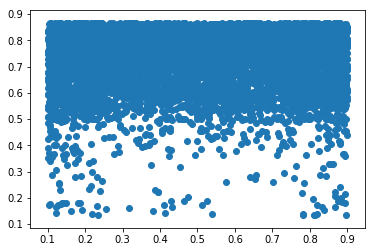

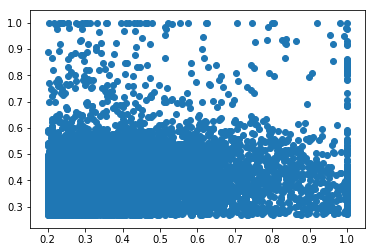

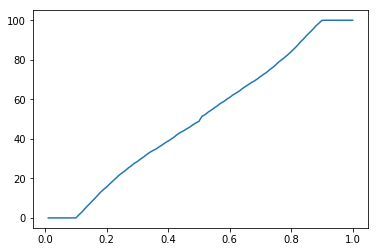

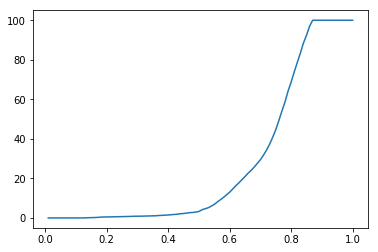

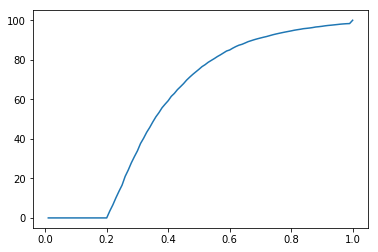

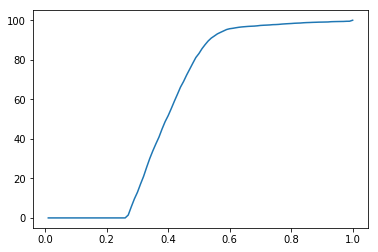

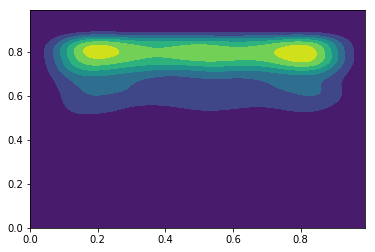

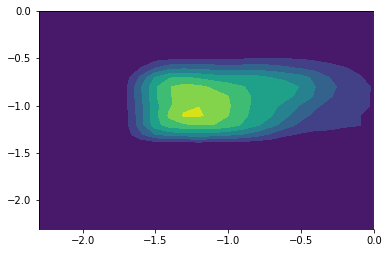

10:51:08 INFO:epoch 0, train loss: 1.81, average train loss: 1.81
10:51:08 INFO:epoch 0, train accuracy: 0.22, average train accuracy: 0.22
10:51:08 INFO:epoch 1, train loss: 1.81, average train loss: 1.81
10:51:08 INFO:epoch 1, train accuracy: 0.25, average train accuracy: 0.23
10:51:09 INFO:epoch 2, train loss: 1.86, average train loss: 1.83
10:51:09 INFO:epoch 2, train accuracy: 0.20, average train accuracy: 0.22
10:51:09 INFO:epoch 3, train loss: 1.70, average train loss: 1.80
10:51:09 INFO:epoch 3, train accuracy: 0.33, average train accuracy: 0.25
10:51:10 INFO:epoch 4, train loss: 1.80, average train loss: 1.80
10:51:10 INFO:epoch 4, train accuracy: 0.17, average train accuracy: 0.23
10:51:10 INFO:epoch 5, train loss: 1.69, average train loss: 1.78
10:51:10 INFO:epoch 5, train accuracy: 0.27, average train accuracy: 0.24
10:51:11 INFO:epoch 6, train loss: 1.72, average train loss: 1.77
10:51:11 INFO:epoch 6, train accuracy: 0.25, average train accuracy: 0.24
10:51:11 INFO:epoch 

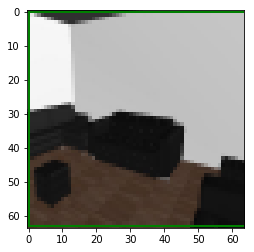

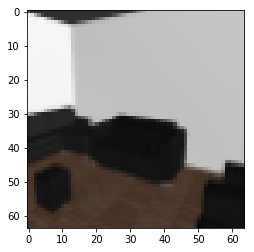

(array([2., 2., 2., 1.], dtype=float32), array([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 9.82804894e-01],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 9.65647101e-01],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 9.65647101e-01],
       [1.19777024e-01, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 6.29256129e-01, 9.13398743e-01],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.19777024e-01, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.87259555e-01, 1.06181622e-01, 1.00000000e+00, 9.79612112e-01],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 9.65647101e-01],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 9.82804894e-01],
       [0.00000000e+00, 0.00000000e+00, 8.12147856e-01, 9.35617089e-01],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 9.79470670e-01],
       [0.

In [77]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = 64
orig_im_size = [64, 64]
im_channel = 3
direction_dim = 4
n_class = 6
tensorboard_path = './tensorboard/debug_direction_attn_100_1'
init_model_path = ''
train_proportion = 1
demo = BaseDirectionAttnDemo(learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, 
                             im_size, orig_im_size, im_channel, direction_dim, n_class, tensorboard_path, 
                             init_model_path, train_proportion)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()
    
demo.test_all()
demo.visualize()

04:45:45 INFO:Baseline with bounding box crop estimated by direction only demo


number of training image: 10742, number of testing image: 4605
train
{3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}
0.25939754780765933
test
{3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}
0.25585542741647843


04:45:46 INFO:epoch 0, train loss: 1.85, average train loss: 1.85
04:45:46 INFO:epoch 0, train accuracy: 0.19, average train accuracy: 0.19
04:45:46 INFO:epoch 1, train loss: 1.77, average train loss: 1.81
04:45:46 INFO:epoch 1, train accuracy: 0.20, average train accuracy: 0.20
04:45:47 INFO:epoch 2, train loss: 1.81, average train loss: 1.81
04:45:47 INFO:epoch 2, train accuracy: 0.19, average train accuracy: 0.19
04:45:47 INFO:epoch 3, train loss: 1.83, average train loss: 1.82
04:45:47 INFO:epoch 3, train accuracy: 0.25, average train accuracy: 0.21
04:45:47 INFO:epoch 4, train loss: 1.73, average train loss: 1.80
04:45:47 INFO:epoch 4, train accuracy: 0.23, average train accuracy: 0.21
04:45:48 INFO:epoch 5, train loss: 1.79, average train loss: 1.80
04:45:48 INFO:epoch 5, train accuracy: 0.20, average train accuracy: 0.21
04:45:48 INFO:epoch 6, train loss: 1.80, average train loss: 1.80
04:45:48 INFO:epoch 6, train accuracy: 0.31, average train accuracy: 0.23
04:45:48 INFO:epoch 

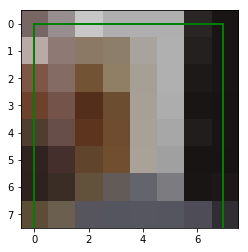

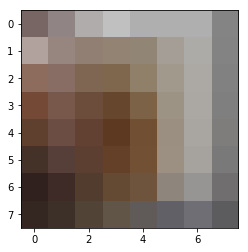

(array([2., 3., 3., 1.], dtype=float32), array([[0.        , 0.        , 0.86736053, 1.        ],
       [0.        , 0.        , 0.44854218, 1.        ],
       [0.        , 0.        , 0.30206978, 0.9687369 ],
       [0.        , 0.        , 0.30790925, 0.88029975],
       [0.        , 0.5292976 , 1.        , 0.72929764],
       [0.        , 0.        , 0.10000002, 0.12691641],
       [0.        , 0.        , 0.30206978, 0.9687369 ],
       [0.        , 0.        , 0.44854218, 1.        ],
       [0.        , 0.        , 0.30206978, 0.9687369 ],
       [0.        , 0.        , 0.30790925, 0.88029975],
       [0.        , 0.9743489 , 0.84942627, 1.        ],
       [0.        , 0.        , 0.37238622, 1.        ],
       [0.        , 0.5178167 , 1.        , 0.71781677],
       [0.        , 0.        , 0.10000002, 0.10560077],
       [0.        , 0.        , 0.10000002, 0.1252703 ],
       [0.        , 0.        , 0.44854218, 1.        ],
       [0.        , 0.49814713, 1.        , 0.6

In [38]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = 8
orig_im_size = [8, 8]
im_channel = 3
direction_dim = 4
n_class = 6
tensorboard_path = './tensorboard/debug_direction_attn_100_1'
init_model_path = ''
train_proportion = 1
demo = BaseDirectionAttnDemo(learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, 
                             im_size, orig_im_size, im_channel, direction_dim, n_class, tensorboard_path, 
                             init_model_path, train_proportion)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()
    
demo.test_all()
demo.visualize()

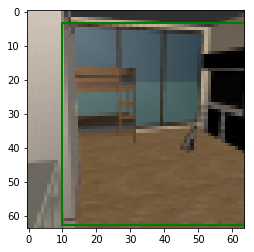

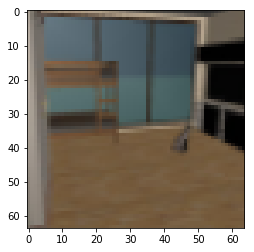

(array([2., 1., 1., 1.], dtype=float32), array([[0.15348613, 0.05161417, 1.        , 0.97829914],
       [0.        , 0.        , 1.        , 0.96982926],
       [0.10146737, 0.        , 1.        , 1.        ],
       [0.        , 0.        , 1.        , 0.9774914 ],
       [0.        , 0.        , 0.9273117 , 0.8901805 ],
       [0.06934607, 0.        , 0.6351149 , 0.95896465],
       [0.        , 0.        , 0.9273117 , 0.8901805 ],
       [0.        , 0.        , 1.        , 0.92645633],
       [0.        , 0.        , 1.        , 1.        ],
       [0.08953381, 0.        , 1.        , 1.        ],
       [0.10536981, 0.        , 1.        , 1.        ],
       [0.        , 0.        , 0.8059927 , 0.9335849 ],
       [0.08953381, 0.        , 1.        , 1.        ],
       [0.        , 0.        , 1.        , 1.        ],
       [0.11713964, 0.        , 1.        , 1.        ],
       [0.        , 0.        , 0.81371355, 0.9408713 ],
       [0.        , 0.        , 1.        , 0.9

In [79]:
demo.visualize()